In [1]:
import os

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.9"
from jax.config import config
# This slows down the computation by ~ x8. But single precision leads to discretization effects.
config.update("jax_enable_x64", True)  
import jax.numpy as jnp
from jax import jit, vmap, random

import sys
sys.path.append("..")
from hyperion.propagate import (
   
    initialize_direction_isotropic,
    make_photon_trajectory_fun,
    make_step_function,
    make_photon_sphere_intersection_func,
    make_cherenkov_spectral_sampling_func,
    make_loop_until_isec_or_maxtime,
    make_loop_for_n_steps,
    make_fixed_pos_time_initializer,
    collect_hits
)
from hyperion.medium import (
     cascadia_ref_index_func,
     mixed_hg_rayleigh_antares,
     sca_len_func_antares
)
from hyperion.constants import Constants
from hyperion.utils import calculate_min_number_steps
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
import seaborn as sns
from scipy.interpolate import UnivariateSpline
import scipy.stats

In [2]:
def wl_to_color(wl, gamma=0.8):
    wl = np.atleast_1d(np.array(wl, copy=True))
    rgb = np.empty((wl.shape[0], 3))
    
    wl[wl < 380] = 380
    wl[wl > 750] = 750
    
    mask = (wl >= 380) & (wl <= 440)
    att = 0.3 + 0.7 * (wl[mask] - 380) / (440 - 380)
    rgb[mask] = np.asarray([((-(wl[mask] - 440) / (440 - 380)) * att) ** gamma, np.zeros(mask.sum()), att ** gamma]).T
    
    mask = (wl >= 440) & (wl <= 490)
    rgb[mask] = np.asarray([np.zeros(mask.sum()), ((wl[mask] - 440) / (490 - 440)) ** gamma, np.ones(mask.sum())]).T
    
    mask = (wl >= 490) & (wl <= 510)
    rgb[mask] = np.asarray([np.zeros(mask.sum()), np.ones(mask.sum()), (-(wl[mask] - 510) / (510 - 490)) ** gamma]).T
    
    mask = (wl >= 510) & (wl <= 580)
    rgb[mask] = np.asarray([((wl[mask] - 510) / (580 - 510)) ** gamma, np.ones(mask.sum()), np.zeros(mask.sum())]).T
    
    mask = (wl >= 580) & (wl <= 645)
    rgb[mask] = np.asarray([np.ones(mask.sum()), (-(wl[mask] - 645) / (645 - 580)) ** gamma, np.zeros(mask.sum())]).T
    
    mask = (wl >= 645) & (wl <= 750)
    att = 0.3 + 0.7 * (750 - wl[mask]) / (750 - 645)
    rgb[mask] = np.asarray([att ** gamma, np.zeros(mask.sum()), np.zeros(mask.sum())]).T
    
    #rgb = np.asarray(rgb * 255, dtype=int)

    return rgb





# Photon Propagation Example

## Visualize Medium Properties

### Scattering Length

(10, 2000)

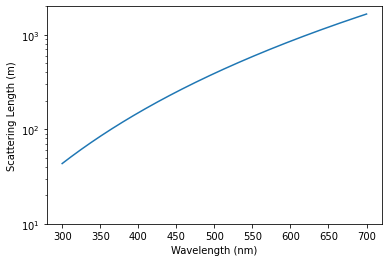

In [3]:
wls = np.linspace(300, 700, 500)

plt.plot(wls, sca_len_func_antares(wls))
plt.xlabel("Wavelength (nm)")
plt.ylabel("Scattering Length (m)")
plt.semilogy()
plt.ylim(10, 2000)

### Cherenkov Emission Spectrum

Text(0.5, 0, 'Wavelength (nm)')

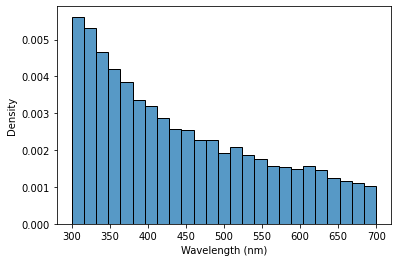

In [4]:
keys = random.split(random.PRNGKey(0), 10000)
samples = vmap(make_cherenkov_spectral_sampling_func([300, 700], cascadia_ref_index_func))(keys)
sns.histplot(samples, stat="density")
plt.xlabel("Wavelength (nm)")


### Absorption Length
Fit a spline to STRAW attenuation length data and use $1/l_{att} = 1/l_{sca} + 1/l_{abs}$

Text(0, 0.5, 'Absorption Length (m)')

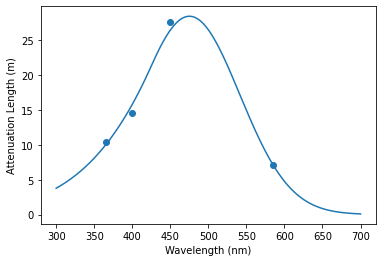

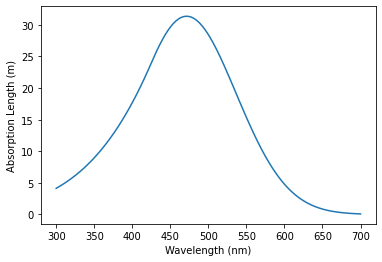

In [5]:
# Attenuationlength from STRAW paper
att_lengths = np.asarray([[365, 10.4], [400, 14.6], [450, 27.7], [585, 7.1]])

spl = UnivariateSpline(att_lengths[:, 0], np.log(att_lengths[:, 1]), k=2, s=0.01)

plt.scatter(att_lengths[:, 0], att_lengths[:, 1])
plt.plot(wls, np.exp(spl(wls)))
plt.xlabel("Wavelength (nm)")
plt.ylabel("Attenuation Length (m)")

plt.figure()

abs_len = lambda wl: 1/(1/np.exp(spl(wl)) - 1/sca_len_func_antares(wl))

plt.plot(wls, abs_len(wls))
plt.xlabel("Wavelength (nm)")
plt.ylabel("Absorption Length (m)")



### Refractive Index

Text(0, 0.5, 'Refractive Index')

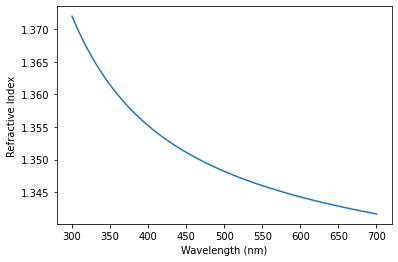

In [6]:
plt.plot(wls, cascadia_ref_index_func(wls))
plt.xlabel("Wavelength (nm)")
plt.ylabel("Refractive Index")

## Photon propagation step-by-step

We are now going to build our photon propagator step-by-step. 
For this we will need:

- A function that initializes the photon state
- A function that updates the photon state (propagate it to the next scattering site)
- A function that loops through the state updater until some condition is met

We can then use jax' vectorization and jit to efficiently parallelize over many photons.
Note: Since we use vectorization to parallelize our code, the simulation runtime is given by the simulation runtime of the slowest photon.
For example: if we vectorize over 1000 photons and 999 photons simulate in 1ns, but 1 photon takes 10ns, then we have to wait for the slow photon to complete simulation before we can retrieve the result.

First we will setup our detector geometry.

### Set detector parameters

In [7]:
# Define emitter position & emission time
emitter_x = jnp.array([0, 0, 0.0])
emitter_t = 0.0

det_dist = 5.0
# Define detector position & sensor radius (sensor is modelled as a sphere)
det_pos = jnp.array([0, 0, det_dist])
det_radius = 0.21

### Create Photon Initializers
Now setup the photon state initializers. We will use a function that injects photons at a fixed position and time and samples the direction and wavelength.
This function returns a dict which represents the initial photon state.

In [8]:
# Isotropic photon emission
emission_dir_init = initialize_direction_isotropic

# Sample wavelength from cherenkov spectrum in (300, 700) nm
wavelength_init = make_cherenkov_spectral_sampling_func([300, 700], cascadia_ref_index_func)

photon_init = make_fixed_pos_time_initializer(emitter_x, emitter_t, emission_dir_init, wavelength_init)

In [9]:
key = random.PRNGKey(0)
photon_init(key)

{'pos': DeviceArray([0., 0., 0.], dtype=float64),
 'dir': DeviceArray([-0.78906843, -0.01722447, -0.61406378], dtype=float64),
 'time': DeviceArray(0., dtype=float64),
 'isec': False,
 'stepcnt': DeviceArray(0, dtype=int32),
 'wavelength': DeviceArray(445.03889935, dtype=float64)}

### Create step function
Next, we are going to create a step function. This function will recieve a photon state, propagate the photon for one scattering step and return a new photon state.

In [10]:
# We want to calculate intersections with a sphere
intersection_f = make_photon_sphere_intersection_func(det_pos, det_radius)

# Use an approximation to the ANTARES scattering function
scattering_function = mixed_hg_rayleigh_antares

# Use the ANTARES wavelength dependent scattering length
scattering_length_function = sca_len_func_antares

# Use the ANTARES wavelength dependent refractive index with cascadia basin properties
ref_index_func = cascadia_ref_index_func

# Create a step function, which will propagate the photon until the next scattering site.
# If the intersection function returns True, only propagate to intersection position.
step_fun = make_step_function(
    intersection_f=intersection_f,
    scattering_function=scattering_function,
    scattering_length_function=scattering_length_function,
    ref_index_func=ref_index_func,
)


### Propagate a photon
In order to propagate our photon for one step, we simply call the step function.

In [11]:
key, subkey = random.split(random.PRNGKey(0), 2)
initial_state = photon_init(key)
final_state = step_fun(initial_state, subkey)
final_state

({'pos': DeviceArray([  63.56413064,  150.63949128, -307.99967007], dtype=float64),
  'dir': DeviceArray([-0.67589732,  0.26264655,  0.688607  ], dtype=float64),
  'time': DeviceArray(1574.28645413, dtype=float64),
  'isec': DeviceArray(False, dtype=bool, weak_type=True),
  'stepcnt': DeviceArray(1, dtype=int32),
  'wavelength': DeviceArray(418.99117993, dtype=float64)},
 DeviceArray([1997759167, 3564182118], dtype=uint32))

### Propagate multiple steps
We can already use this function to build a very basic propagation loop.

Text(0, 0.5, 'y (m)')

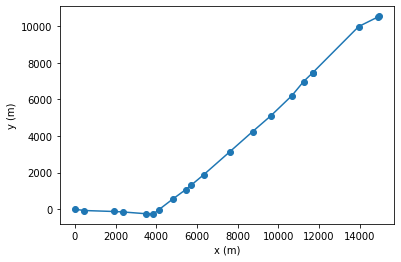

In [12]:
key, subkey = random.split(random.PRNGKey(1), 2)
state = photon_init(subkey)
positions = [state["pos"]]

# JIT the step function
step_fun_j = jit(step_fun)
for i in range(20):
    state, key = step_fun_j(state, key)
    positions.append(np.asarray(state["pos"]))

positions = np.asarray(positions)
plt.plot(positions[:, 0], positions[:, 1], "o-")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
    

### Propagate multiple photons
It's easy to vectorize the propagation loop over multiple photons

Text(0, 0.5, 'z[m]')

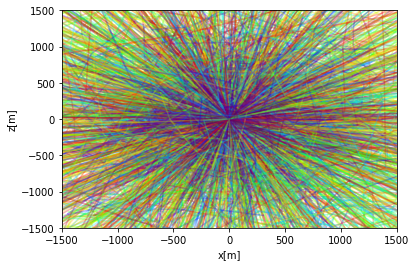

In [13]:
key, subkey = random.split(random.PRNGKey(32), 2)
n_photons = 5000


# vmap and jit
step_fun_j = jit(vmap(step_fun, in_axes=0))
state = vmap(photon_init, in_axes=0)(random.split(subkey, n_photons))
positions = [np.asarray(state["pos"])]
wavelengths = [np.asarray(state["wavelength"])]

key = random.split(key, n_photons)

for i in range(10):
    state, key = step_fun_j(state, key)
    positions.append(np.asarray(state["pos"]))
    wavelengths.append(np.asarray(state["wavelength"]))

    
positions = np.asarray(positions)

for i_photon in range(n_photons):
    plt.plot(positions[:, i_photon, 0], positions[:, i_photon, 2], c=tuple(wl_to_color(wavelengths[0][i_photon]).squeeze()), alpha=0.3);
plt.xlim(-1500, 1500)
plt.ylim(-1500, 1500)
plt.xlabel("x[m]")
plt.ylabel("z[m]")
    

The intersection is evaluated during the evaluation of the step function.

In [14]:
print(np.any(state["isec"]))

True


(-2.5, 2.5)

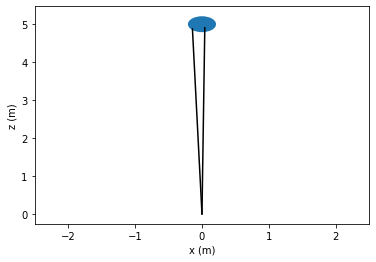

In [15]:
isec_photon = np.asarray(state["isec"])
plt.plot(positions[:, isec_photon, 0], positions[:, isec_photon, 2], color="k")
plt.xlabel("x (m)")
plt.ylabel("z (m)")

circ = plt.Circle((det_pos[0], det_pos[2]), det_radius)
plt.gca().add_patch(circ)
plt.xlim(-2.5, 2.5)


### Using builtin trajectory and looping functions
hyperion provides convenience functions to take care of initializing the photons and looping over the step function.
In the following we are going to use a looping function that propagated photons until they either hit the detector, or they reach a maximum propagation distance (time).

In [16]:
# Get speed of light in medium at 400nm
c_medium = Constants.BaseConstants.c_vac / cascadia_ref_index_func(400)

# Set the maximum time a photon is tracked. Here max time residual=700ns
# Note that the runtime scales with the number of scattering steps.
# For small scattering lengths, the step size can become very small
max_time = jnp.linalg.norm(emitter_x - det_pos) / c_medium + 700

# Propagation is run until either photon intersects or max_time is reached
loop_func = make_loop_until_isec_or_maxtime(max_time)

# make a trajectory function
trajec_fun = make_photon_trajectory_fun(
    step_fun,
    photon_init,
    loop_func=loop_func,
)

# Create a compiled and vectorized trajectory function
trajec_fun_v = jit(vmap(trajec_fun, in_axes=[0]))

In [17]:
key = random.PRNGKey(0)

isec_times = []
ph_thetas = []
stepss = []
nphotons = int(1e6)
isec_poss = []

initial_state, final_state = trajec_fun_v(random.split(key, num=nphotons))


## Plot propagation statistics

### Timing

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Time per photon (ns)')

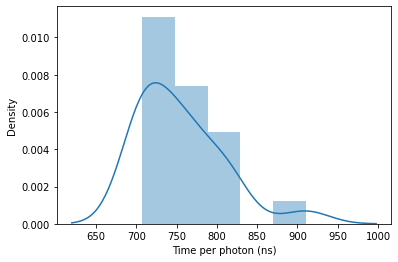

In [18]:
from time import time
keys = random.split(random.PRNGKey(1), 20)

runtimes = []
for key in keys:
    del initial_state
    del final_state
    subkeys = random.split(key, num=nphotons)
    start = time()
    initial_state, final_state = trajec_fun_v(subkeys)
    final_state["time"].block_until_ready()
    
    runtimes.append(time() - start)
sns.distplot(np.asarray(runtimes) * 1E9 / nphotons)
plt.xlabel("Time per photon (ns)")
    

In [19]:
import jax
with jax.profiler.trace("/tmp/tensorboard"):
    initial_state, final_state = trajec_fun_v(random.split(key, num=nphotons))
    final_state["time"].block_until_ready()

2022-01-17 14:55:43.694346: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so.11.4'; dlerror: libcupti.so.11.4: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11/lib64/:/usr/local/nvidia/lib:/usr/local/nvidia/lib64


### Step count

The runtime is determined by the max number of steps of *any* photon

[]

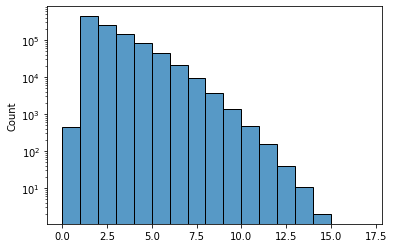

In [20]:
sns.histplot(final_state["stepcnt"], bins=np.arange(0, 18))
plt.semilogy()

We see that the simulation is rather inefficient, runtime-wise. Most of the photons are only tracked for a couple of steps until they either intersect or the max time is reached.

Due to the wavelength dependent scattering length, the step size is correlated to wavelength:

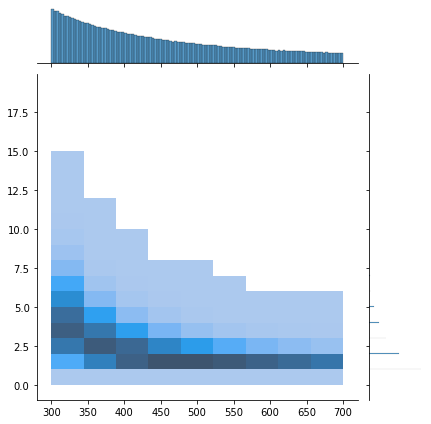

In [21]:
sns.jointplot(x=final_state["wavelength"], y=final_state["stepcnt"], kind="hist", bins=[np.linspace(300, 700, 10), np.arange(0, 20)])

Due to the small scattering length at lower wavelengths, we have to do more scattering steps per time-interval.
We could optimize this by splitting the simulation by wavelength or using a different emission spectrum that optimizes runtime.

### Arrival time
Plot the time residual (arrival time relative to a direct photon at 700nm wavelength.
Note, this does not yet include absorption.

Text(0.5, 0, 'Time Residual(ns)')

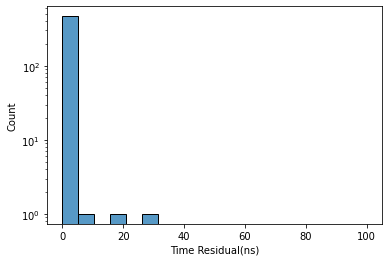

In [22]:
c_medium_f = lambda wl: Constants.BaseConstants.c_vac / cascadia_ref_index_func(wl)

time_res = final_state["time"][final_state["isec"]] - (det_dist-det_radius) / (c_medium_f(700)/1E9)
sns.histplot(time_res, bins=np.linspace(-0, 100, 20))
plt.semilogy()
plt.xlabel("Time Residual(ns)")

Now include absorption via weights:

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"


Text(0.5, 0, 'Time Residual(ns)')

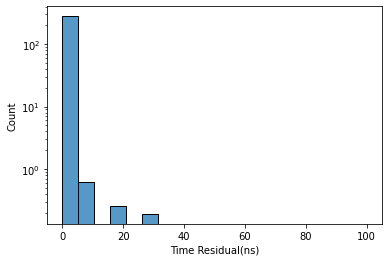

In [23]:
prop_dist = final_state["time"] * c_medium_f(final_state["wavelength"])/1E9 
abs_weight = np.exp(-prop_dist / abs_len(final_state["wavelength"]))

sns.histplot(x=time_res, bins=np.linspace(-0, 100, 20), weights=abs_weight[final_state["isec"]])
plt.semilogy()
plt.xlabel("Time Residual(ns)")


### Number of steps for detected photons
We can also look at the scattering step distribution for detected photons:

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"


Text(0.5, 0, 'Steps')

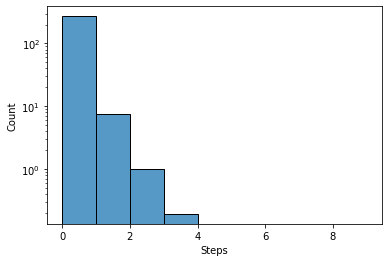

In [24]:
sns.histplot(x=final_state["stepcnt"][final_state["isec"]], bins=np.arange(10), weights=abs_weight[final_state["isec"]])
plt.semilogy()
plt.xlabel("Steps")

We can safely reduce the number of steps to 6.
Note: The path length (and thus time elapsed) of a photon after $n$ steps with mean free path $\lambda_{sca}$ is an Erlang distribution with $k=n$ and $\lambda = \lambda_{sca}$.
We can thus easily obtain the distribution of the photon time after e.g. $n=6$ steps. If we want to simulate time-residuals up to e.g. $t_{upper}=500ns$, we can calculate the probablity of a photon having a time smaller than $t_{upper}$ after 6 steps. This is the probability that a photon has not yet travelled a distance that corresponds to a time residual of $t_{upper}$. 

0.05105059211473392


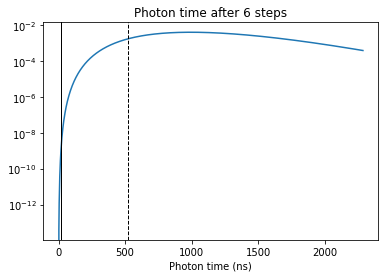

In [25]:
xs = np.linspace(0, 500, 1000)
wl = 300
n_steps = 6
dist = scipy.stats.erlang(n_steps, scale=sca_len_func_antares(wl))
t_elapsed = xs / c_medium_f(wl) * 1E9 

t_geo_low = (det_dist-det_radius) / (c_medium_f(wl)/1E9)
t_geo_high = t_geo_low + 500

plt.plot(t_elapsed, dist.pdf(xs))
plt.axvline(t_geo_low, color="k", ls="-", lw=1)
plt.axvline(t_geo_high, color="k", ls="--", lw=1)
plt.xlabel("Photon time (ns)")
plt.title(f"Photon time after {n_steps} steps")
plt.semilogy()

prob = dist.cdf(t_geo_high * (c_medium_f(wl)/1E9))
print(prob)


Thus, when using 6 steps at this distance, we loose at most 5% of the photons at this wavelength. Larger wavelengths will be even less problematic due to the larger scattering length.
We can also calculate the number of steps needed as function of distance to loose at most 1% of the photons:

12


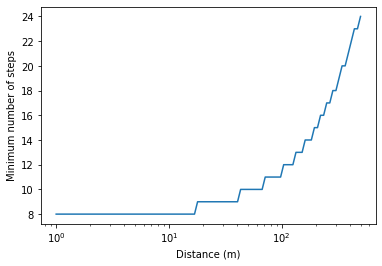

In [26]:
p_thr = 0.01
min_steps = []
det_dists = np.logspace(0, np.log10(500), 100)
for dd in det_dists:
    t_geo = (dd-det_radius) / (c_medium_f(wl)/1E9) + 500   
    func = lambda step: scipy.stats.gamma.cdf(t_geo * (c_medium_f(wl)/1E9), step, scale=sca_len_func_antares(wl)) - 0.01
    lim = scipy.optimize.brentq(func, 2, 50)
    min_steps.append(lim)
plt.plot(det_dists, np.ceil(min_steps))
plt.semilogx()
plt.xlabel("Distance (m)")
plt.ylabel("Minimum number of steps")
    
print(calculate_min_number_steps(cascadia_ref_index_func, sca_len_func_antares, 100, 500, 300, 0.01))

In [27]:
loop_func = make_loop_for_n_steps(8)
nphotons = int(1E6)
# make a trajectory function
trajec_fun = make_photon_trajectory_fun(
    step_fun,
    photon_init,
    loop_func=loop_func,
)

# Create a compiled and vectorized trajectory function
trajec_fun_v = jit(vmap(trajec_fun, in_axes=[0]))

In [28]:
_ = trajec_fun_v(random.split(key, num=nphotons))

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Time per photon (ns)')

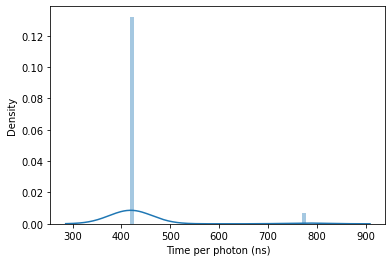

In [29]:
from time import time
keys = random.split(random.PRNGKey(1), 20)

runtimes = []
for key in keys:
    subkeys = random.split(key, num=nphotons)
    start = time()
    initial_state, final_state = trajec_fun_v(subkeys)
    final_state["time"].block_until_ready()
    runtimes.append(time() - start)
sns.distplot(np.asarray(runtimes) * 1E9 / nphotons)
plt.xlabel("Time per photon (ns)")
    

## Propagate multiple batches of photons
We can use another convenience function to propagate multiple batches of photons, and record only those that have hit our detector.

In [30]:
max_time = jnp.linalg.norm(emitter_x - det_pos) / c_medium + 700
loop_func = make_loop_until_isec_or_maxtime(max_time)

trajec_fun = make_photon_trajectory_fun(
    step_fun,
    photon_init,
    loop_func=loop_func,
)

# Create a compiled and vectorized trajectory function
trajec_fun_v = jit(vmap(trajec_fun, in_axes=[0]))
data = collect_hits(trajec_fun_v, 1E6, 50)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"


Text(0.5, 0, 'Time (ns)')

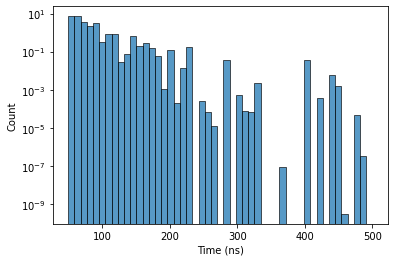

In [31]:
c_medium_f = lambda wl: Constants.BaseConstants.c_vac / cascadia_ref_index_func(wl)
abs_weight = np.exp(-data[0] * c_medium_f(data[-1])/1E9 / abs_len(data[-1]))
sns.histplot(x=data[0], bins = np.linspace(50, 500, 50), weights=abs_weight)
plt.semilogy()
plt.xlabel("Time (ns)")

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"


Text(0.5, 0, 'Steps')

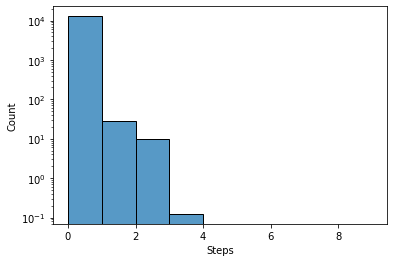

In [32]:
sns.histplot(x=data[2], bins=np.arange(0, 10), weights=abs_weight)
plt.semilogy()
plt.xlabel("Steps")

We can again tune the step_size. At this distance, a step size of 8 guarantees that the error is < 1%.

In [33]:
loop_func = make_loop_for_n_steps(8)

# make a trajectory function
trajec_fun = make_photon_trajectory_fun(
    step_fun,
    photon_init,
    loop_func=loop_func,
)

# Create a compiled and vectorized trajectory function
trajec_fun_v = jit(vmap(trajec_fun, in_axes=[0]))
data = collect_hits(trajec_fun_v, 1E6, 200)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:385: UserWarning: `bins` cannot be 'auto' when using weights. Setting `bins=10`, but you will likely want to adjust.
  warnings.warn(msg, UserWarning)


Text(0.5, 0, 'Wavelength (nm)')

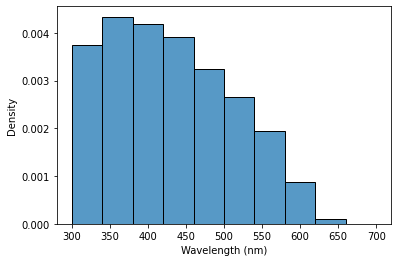

In [34]:
abs_weight = np.exp(-data[0] * c_medium_f(data[-1])/1E9 / abs_len(data[-1]))

sns.histplot(x=data[-1], weights=abs_weight, stat="density")
plt.xlabel("Wavelength (nm)")

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: Fut

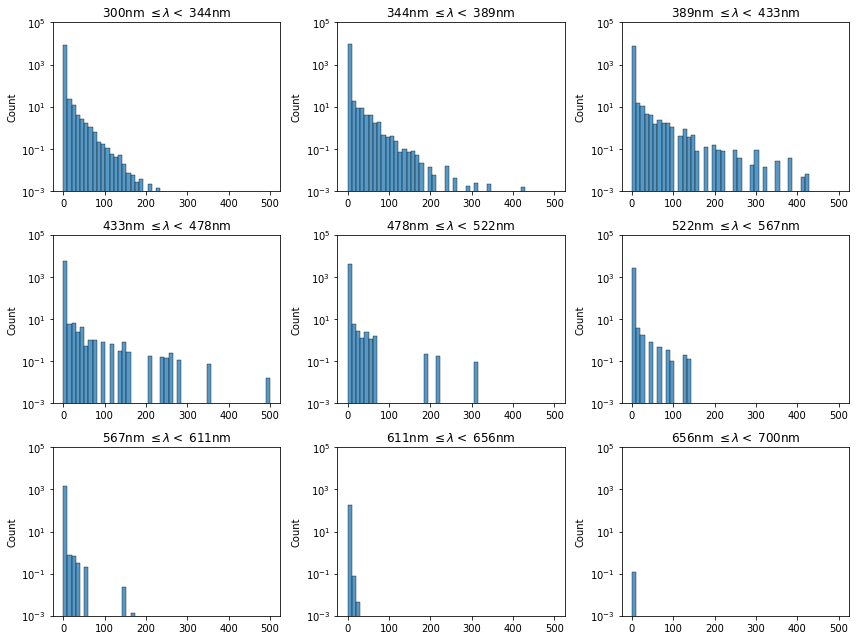

In [36]:
tres = data[0] - (det_dist-det_radius) / (c_medium_f(350)/1E9)

wl_bins = np.linspace(300, 700, 10)

fig, axs = plt.subplots(3, 3, figsize=(3*4, 3*3))

for i, ax in zip(range(len(wl_bins)-1), axs.ravel()):
    wl_sel = (wl_bins[i] < data[-1]) & (wl_bins[i+1] > data[-1])
    sns.histplot(x=tres[wl_sel], weights=abs_weight[wl_sel], bins=np.linspace(0, 500, 50), ax=ax)
    ax.set_yscale("log")
    ax.set_ylim(1E-3, 1E5)
    ax.set_title(f"{wl_bins[i]:.0f}nm $\leq \lambda <$ {wl_bins[i+1]:.0f}nm")
plt.tight_layout()